<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq


from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')


# Import user defined python functions
import model_evaluation_functions
import ratings_functions
importlib.reload(model_evaluation_functions)
importlib.reload(ratings_functions)

from ratings_functions import *
from model_evaluation_functions import *


In [ ]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [44]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    SELECT * FROM preparation_layer.view_fa_cup_scores WHERE season_year NOT IN ('21/22', '22/23') ORDER BY sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)




,team_no,fold_number


,metric_id,metric


In [105]:
def predict_winner_upset (home_team_no, away_team_no, home_team_league_level, away_team_league_level, ranked_ratings):
    home_team_info = next((info for info in ranked_ratings if info[0] == home_team_no), None)
    away_team_info = next((info for info in ranked_ratings if info[0] == away_team_no), None)

    if home_team_info is None or away_team_info is None:
        raise ValueError("Team number not found in ratings list.")

    home_team_rating, home_team_rank = home_team_info[1], home_team_info[2]
    away_team_rating, away_team_rank = away_team_info[1], away_team_info[2]

    # Calculate the basic probability of the higer ranked team winning based on rank our of 64 teams

    home_team_win_probability = 1 - (home_team_rank / (home_team_rank + away_team_rank))
    away_team_win_probability = 1 - (away_team_rank / (home_team_rank + away_team_rank))


    # Determine the predicted winner and if it's an upset
    if home_team_rating > away_team_rating:
        predicted_winner = home_team_no
        predicted_upset = 1 if home_team_league_level > away_team_league_level else 0
    else:
        predicted_winner = away_team_no
        predicted_upset = 1 if away_team_league_level > home_team_league_level else 0

    # Probaility of upset based on league level and rank differnce
    if home_team_league_level > away_team_league_level:
       upset_probability = home_team_win_probability
    else:
       upset_probability = away_team_win_probability

    return predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability

In [102]:
def run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds, random_state=47):
    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    fold_train_accuracies = []
    fold_train_recalls = []
    fold_test_accuracies = []
    fold_test_recalls = []
    all_y_train_true = []
    all_y_train_pred = []
    all_y_train_pred_proba = []
    all_y_test_true = []
    all_y_test_pred = []
    all_y_test_pred_proba = []
    fold_ratings = []
    test_predictions = []

    # Iterate over the folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(fa_cup_scores_df, fa_cup_scores_df['actual_upset']), start=1):
        print(f"Fold {fold}/{num_folds}")

        # Split the data into training and test sets
        train_data = fa_cup_scores_df.iloc[train_idx]
        test_data = fa_cup_scores_df.iloc[test_idx]

        # Call rating function
        if ratings_model in ['borda_count', 'average_rank', 'local_kemeny_optimisation']:
            ratings = ratings_function(fold)
        else:
            ratings = ratings_function(train_data)

        # Add ranks based on the sorted order
        sorted_ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        ranked_ratings = [(team_no, rating, index + 1) for index, (team_no, rating) in enumerate(sorted_ratings)]
        print(ranked_ratings)

        # Append the ratings to the list
        ratings_list = [(ratings_model, fold, team_no, rating) for team_no, rating in ratings]
        fold_ratings.extend(ratings_list)

         # Predict upsets for train and test data
        # Predict upsets for train data
        train_actual_upsets = []
        train_predicted_upsets = []
        train_upset_probabilities = []

        for _, row in train_data.iterrows():
            predicted_winner, predicted_upset, home_team_rating, away_team_rating,  home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
                row['home_team_no'], row['away_team_no'],
                row['home_team_league_level'], row['away_team_league_level'],
                ranked_ratings
            )
            actual_upset = row['actual_upset']
            rating_diff = home_team_rating - away_team_rating
            train_actual_upsets.append(actual_upset)
            train_predicted_upsets.append(predicted_upset)
            train_upset_probabilities.append(upset_probability)
            #print(upset_probability)

        # Calculate train metrics
        train_accuracy = accuracy_score(train_actual_upsets, train_predicted_upsets)
        train_recall = recall_score(train_actual_upsets, train_predicted_upsets)
        fold_train_accuracies.append(train_accuracy)
        fold_train_recalls.append(train_recall)
        all_y_train_true.extend(train_actual_upsets)
        all_y_train_pred.extend(train_predicted_upsets)
        all_y_train_pred_proba.extend(train_upset_probabilities)

        # Predict upsets for test data
        test_actual_upsets = []
        test_predicted_upsets = []
        test_upset_probabilities = []

        for _, row in test_data.iterrows():
            predicted_winner, predicted_upset, home_team_rating, away_team_rating, home_team_rank, away_team_rank, upset_probability = predict_winner_upset(
                row['home_team_no'], row['away_team_no'],
                row['home_team_league_level'], row['away_team_league_level'],
                ranked_ratings
            )
            actual_upset = row['actual_upset']
            rating_diff = home_team_rating - away_team_rating
            test_actual_upsets.append(actual_upset)
            test_predicted_upsets.append(predicted_upset)
            test_upset_probabilities.append(upset_probability)

            test_predictions.append({
              'ratings_model': ratings_model,
              'fold_number': fold,
              'match_id': row['match_id'],
              'home_team_no': row['home_team_no'],
              'home_team_league_level': row['home_team_league_level'],
              'away_team_no': row['away_team_no'],
              'away_team_league_level': row['away_team_league_level'],
              'home_team_rating': home_team_rating,
              'away_team_rating': away_team_rating,
              'home_team_rank': home_team_rank,
              'away_team_rank': away_team_rank,
              'predicted_winner': predicted_winner,
              'actual_winner': row['actual_winning_team_no'],
              'actual_upset': actual_upset,
              'predicted_upset': predicted_upset,
              'upset_probability': upset_probability,
            })

        # Calculate test metrics
        test_accuracy = accuracy_score(test_actual_upsets, test_predicted_upsets)
        test_recall = recall_score(test_actual_upsets, test_predicted_upsets)
        fold_test_accuracies.append(test_accuracy)
        fold_test_recalls.append(test_recall)
        all_y_test_true.extend(test_actual_upsets)
        all_y_test_pred.extend(test_predicted_upsets)
        all_y_test_pred_proba.extend(test_upset_probabilities)

        print(f"Fold {fold} Train Accuracy: {train_accuracy:.3f}, Train Recall: {train_recall:.3f}")
        print(f"Fold {fold} Test Accuracy: {test_accuracy:.3f}, Test Recall: {test_recall:.3f}")

        print(all_y_train_true)
        print(all_y_train_pred_proba)

        test_predictions_df = pd.DataFrame(test_predictions)

        # Create ratings DataFrame
        ratings_df = pd.DataFrame(fold_ratings, columns=['ratings_model', 'fold_number', 'team_no', 'rating'])
        ratings_df = ratings_df.sort_values(['team_no', 'fold_number'])
        ratings_df['rank'] = ratings_df.groupby('fold_number')['rating'].rank(ascending=False, method='dense').astype(int)


    return ratings_df, test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, ratings_model

In [106]:
# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)

,team_no,fold_number


,metric_id,metric


Fold 1/5
[(1, 1.0, 1), (2, 0.5, 2), (3, 0.3333333333333333, 3), (4, 0.25, 4), (5, 0.2, 5), (6, 0.16666666666666666, 6), (7, 0.14285714285714285, 7), (8, 0.125, 8), (9, 0.1111111111111111, 9), (10, 0.1, 10), (11, 0.09090909090909091, 11), (12, 0.08333333333333333, 12), (13, 0.07692307692307693, 13), (14, 0.07142857142857142, 14), (15, 0.06666666666666667, 15), (16, 0.0625, 16), (17, 0.058823529411764705, 17), (18, 0.05555555555555555, 18), (19, 0.05263157894736842, 19), (20, 0.05, 20), (21, 0.047619047619047616, 21), (22, 0.045454545454545456, 22), (23, 0.043478260869565216, 23), (24, 0.041666666666666664, 24), (25, 0.04, 25), (26, 0.038461538461538464, 26), (27, 0.037037037037037035, 27), (28, 0.03571428571428571, 28), (29, 0.034482758620689655, 29), (30, 0.03333333333333333, 30), (31, 0.03225806451612903, 31), (32, 0.03125, 32), (33, 0.030303030303030304, 33), (34, 0.029411764705882353, 34), (35, 0.02857142857142857, 35), (36, 0.027777777777777776, 36), (37, 0.02702702702702703, 37), 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,home_team_rank,away_team_rank,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1,1428623,27,2,1,1,0.037037,1.000000,27,1,1,1,0,0,0.035714
2,basic_position,1,201912,1,1,25,2,1.000000,0.040000,1,25,1,1,0,0,0.038462
3,basic_position,1,1324961,54,4,2,1,0.018519,0.500000,54,2,2,2,0,0,0.035714
4,basic_position,1,50127,2,1,41,2,0.500000,0.024390,2,41,2,2,0,0,0.046512
5,basic_position,1,846113,2,1,42,2,0.500000,0.023810,2,42,2,2,0,0,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,basic_position,5,274803,58,4,40,2,0.017241,0.025000,58,40,40,40,0,0,0.408163
302,basic_position,5,304202,42,2,55,3,0.023810,0.018182,42,55,42,55,1,0,0.432990
303,basic_position,5,1041547,46,3,57,4,0.021739,0.017544,46,57,46,46,0,0,0.446602
304,basic_position,5,836539,47,3,64,6,0.021277,0.015625,47,64,47,47,0,0,0.423423


,ratings_model,fold_number,team_no,rating,rank
1,basic_position,1,1,1.000000,1
2,basic_position,2,1,1.000000,1
3,basic_position,3,1,1.000000,1
4,basic_position,4,1,1.000000,1
5,basic_position,5,1,1.000000,1
...,...,...,...,...,...
316,basic_position,1,64,0.015625,64
317,basic_position,2,64,0.015625,64
318,basic_position,3,64,0.015625,64
319,basic_position,4,64,0.015625,64


,team_no,fold_number,basic_position
0,1,1,1
1,1,2,1
2,1,3,1
3,1,4,1
4,1,5,1
...,...,...,...
315,64,1,64
316,64,2,64
317,64,3,64
318,64,4,64


Model name received: 'basic_position'
0.5373193183111064
0.5373193183111064


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-validation Train Accuracy Mean,0.731
1,2,Cross-validation Train Accuracy Standard Devia...,0.002
2,3,Cross-validation Test Accuracy Mean,0.731
3,4,Cross-validation Test Accuracy Standard Deviation,0.008
4,5,Cross-validation Train Recall Mean,0.000
5,6,Cross-validation Train Recall Standard Deviation,0.000
6,7,Cross-validation Test Recall Mean,0.000
7,8,Cross-validation Test Recall Standard Deviation,0.000
8,9,Cross-validation Train Log Loss,0.537
9,10,Cross-validation Test Log Loss,0.537


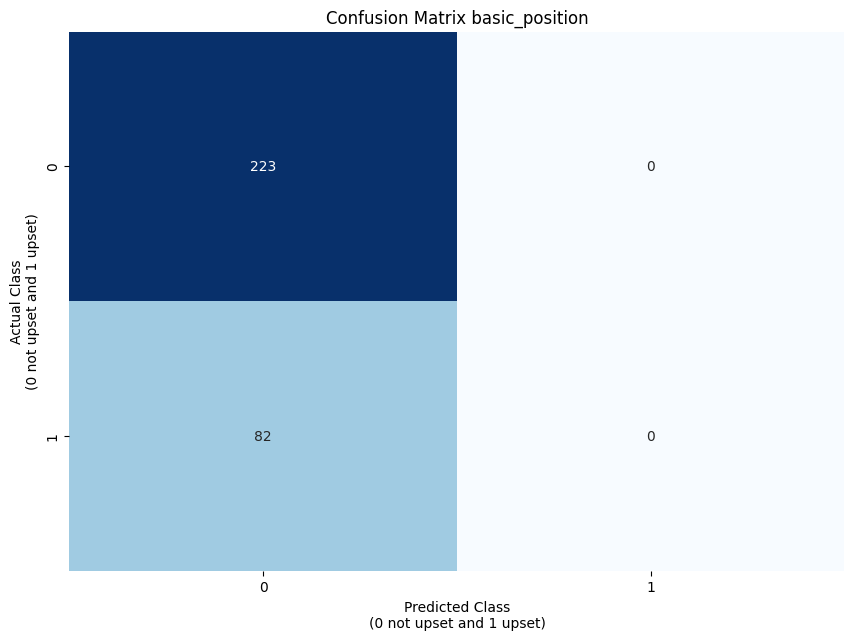

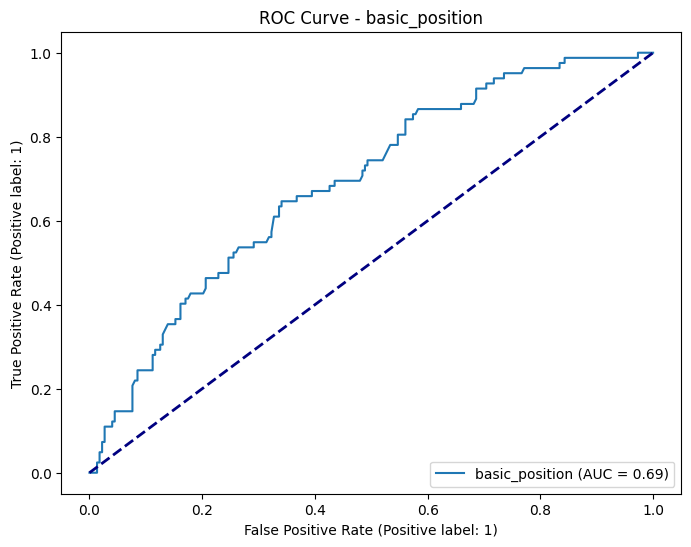

In [107]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation

(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
#load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



In [1]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = massey_ratings
num_folds = 5

# Call ratings function and run cross validation

(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

NameError: name 'massey_ratings' is not defined

In [ ]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation

(ratings_df,test_predictions_df, all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred,
 fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls,
 all_y_train_pred_proba, all_y_test_pred_proba, ratings_model) = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)


# Display results
test_predictions_df.index = range(1, len(test_predictions_df) + 1)
display(test_predictions_df)

ratings_df.index = range(1, len(ratings_df) + 1)
display(ratings_df)

# Load predictions and ratinbgs to Google Big Query
load_predictions_and_ratings_to_bigquery(client, test_predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
model_name_ranking = ratings_model
results_df, cm_fig, roc_fig = create_model_results_df(all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking)

results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = keener_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



In [ ]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


In [ ]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    #credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': all_ranks_df['basic_position'].tolist(),
        'massey': all_ranks_df['massey'].tolist(),
        'colley': all_ranks_df['colley'].tolist(),
        'keener': all_ranks_df['keener'].tolist(),
        'trueskill': all_ranks_df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['borda_count'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


In [ ]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df.to_excel("all_ranking_results.xlsx")

In [ ]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['recalls'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

